In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
import optuna
import warnings
warnings.filterwarnings("ignore")
import shap

c:\Users\ACER\anaconda3\envs\songPopularity\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Normalized, one-hot-encoded, and feature-engineered dataset
data = pd.read_csv('final_data.csv')

In [3]:
# Splitting features and target variable
X = data.drop("popularity", axis=1)   # features
y = data["popularity"]               # target

In [4]:
# Split the dataset into training(%80) and test(%20) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(22684, 42) (5672, 42)


In [5]:
y_train_pred_mean = [y_train.mean()] * len(y_train)
y_test_pred_mean  = [y_train.mean()] * len(y_test)

print("BASELINE (train): MAE, RMSE, R2 =",
      mean_absolute_error(y_train, y_train_pred_mean),
      np.sqrt(mean_squared_error(y_train, y_train_pred_mean)),
      r2_score(y_train, y_train_pred_mean))

print("BASELINE (test): MAE, RMSE, R2 =",
      mean_absolute_error(y_test, y_test_pred_mean),
      np.sqrt(mean_squared_error(y_test, y_test_pred_mean)),
      r2_score(y_test, y_test_pred_mean))

BASELINE (train): MAE, RMSE, R2 = 19.8936972829277 23.690550511863467 0.0
BASELINE (test): MAE, RMSE, R2 = 19.914148711219504 23.747533757202742 -3.851367790019822e-06


In [6]:
# Base Random Forest model evaluation with cross-validation
rf_base = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

scores = cross_val_score(
    rf_base,
    X_train, y_train,
    cv=5,
    scoring="neg_mean_absolute_error"
)

print("Base RF CV MAE:", -scores.mean())
print("STD:", scores.std())

Base RF CV MAE: 10.264282817802378
STD: 0.08916916494407318


In [7]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "max_depth": trial.suggest_int("max_depth", 5, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 40),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", 0.3, 0.5, 0.7]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestRegressor(**params)

    score = cross_val_score(
        model,
        X_train,
        y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    ).mean()

    return -score   # MAE minimize edildiği için


In [8]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60, show_progress_bar=True)


[I 2025-12-09 23:52:25,720] A new study created in memory with name: no-name-2ebc96ac-5cf3-4234-ab94-8c2b03fa1913
Best trial: 0. Best value: 10.8301:   2%|▏         | 1/60 [00:15<15:29, 15.76s/it]

[I 2025-12-09 23:52:41,479] Trial 0 finished with value: 10.830132347665302 and parameters: {'n_estimators': 803, 'max_depth': 21, 'min_samples_split': 22, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 10.830132347665302.


Best trial: 1. Best value: 10.0309:   3%|▎         | 2/60 [01:10<37:14, 38.53s/it]

[I 2025-12-09 23:53:35,943] Trial 1 finished with value: 10.030912630368139 and parameters: {'n_estimators': 808, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 0.7}. Best is trial 1 with value: 10.030912630368139.


Best trial: 2. Best value: 10.0185:   5%|▌         | 3/60 [01:33<30:08, 31.74s/it]

[I 2025-12-09 23:53:59,600] Trial 2 finished with value: 10.018498528170262 and parameters: {'n_estimators': 334, 'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 0.7}. Best is trial 2 with value: 10.018498528170262.


Best trial: 2. Best value: 10.0185:   7%|▋         | 4/60 [01:49<23:32, 25.23s/it]

[I 2025-12-09 23:54:14,848] Trial 3 finished with value: 10.276890795121513 and parameters: {'n_estimators': 476, 'max_depth': 6, 'min_samples_split': 35, 'min_samples_leaf': 1, 'max_features': 0.7}. Best is trial 2 with value: 10.018498528170262.


Best trial: 2. Best value: 10.0185:   8%|▊         | 5/60 [02:14<23:01, 25.12s/it]

[I 2025-12-09 23:54:39,782] Trial 4 finished with value: 10.14107608278626 and parameters: {'n_estimators': 807, 'max_depth': 22, 'min_samples_split': 31, 'min_samples_leaf': 1, 'max_features': 0.3}. Best is trial 2 with value: 10.018498528170262.


Best trial: 5. Best value: 9.97803:  10%|█         | 6/60 [02:43<24:03, 26.74s/it]

[I 2025-12-09 23:55:09,654] Trial 5 finished with value: 9.978028959983742 and parameters: {'n_estimators': 515, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 0.7}. Best is trial 5 with value: 9.978028959983742.


Best trial: 5. Best value: 9.97803:  12%|█▏        | 7/60 [02:56<19:29, 22.07s/it]

[I 2025-12-09 23:55:22,111] Trial 6 finished with value: 10.620046572003822 and parameters: {'n_estimators': 709, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.3}. Best is trial 5 with value: 9.978028959983742.


Best trial: 5. Best value: 9.97803:  13%|█▎        | 8/60 [03:22<20:19, 23.44s/it]

[I 2025-12-09 23:55:48,502] Trial 7 finished with value: 10.003316802120809 and parameters: {'n_estimators': 424, 'max_depth': 25, 'min_samples_split': 32, 'min_samples_leaf': 5, 'max_features': 0.7}. Best is trial 5 with value: 9.978028959983742.


Best trial: 5. Best value: 9.97803:  15%|█▌        | 9/60 [03:30<15:52, 18.68s/it]

[I 2025-12-09 23:55:56,703] Trial 8 finished with value: 10.8898257549965 and parameters: {'n_estimators': 462, 'max_depth': 25, 'min_samples_split': 24, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 5 with value: 9.978028959983742.


Best trial: 5. Best value: 9.97803:  17%|█▋        | 10/60 [03:38<12:45, 15.31s/it]

[I 2025-12-09 23:56:04,457] Trial 9 finished with value: 12.508561623842827 and parameters: {'n_estimators': 806, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 5 with value: 9.978028959983742.


Best trial: 5. Best value: 9.97803:  18%|█▊        | 11/60 [04:03<14:58, 18.35s/it]

[I 2025-12-09 23:56:29,696] Trial 10 finished with value: 9.978716735163644 and parameters: {'n_estimators': 617, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 5 with value: 9.978028959983742.


Best trial: 5. Best value: 9.97803:  20%|██        | 12/60 [04:28<16:09, 20.20s/it]

[I 2025-12-09 23:56:54,132] Trial 11 finished with value: 9.980327954724887 and parameters: {'n_estimators': 621, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 0.5}. Best is trial 5 with value: 9.978028959983742.


Best trial: 12. Best value: 9.9721:  22%|██▏       | 13/60 [04:52<16:43, 21.35s/it]

[I 2025-12-09 23:57:18,126] Trial 12 finished with value: 9.97209741539479 and parameters: {'n_estimators': 583, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  23%|██▎       | 14/60 [05:24<18:46, 24.50s/it]

[I 2025-12-09 23:57:49,901] Trial 13 finished with value: 9.978290942974573 and parameters: {'n_estimators': 555, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  25%|██▌       | 15/60 [05:50<18:49, 25.10s/it]

[I 2025-12-09 23:58:16,401] Trial 14 finished with value: 9.978911161272467 and parameters: {'n_estimators': 545, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  27%|██▋       | 16/60 [06:25<20:33, 28.03s/it]

[I 2025-12-09 23:58:51,240] Trial 15 finished with value: 9.976836722964071 and parameters: {'n_estimators': 691, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  28%|██▊       | 17/60 [06:49<19:14, 26.85s/it]

[I 2025-12-09 23:59:15,327] Trial 16 finished with value: 10.028673644548194 and parameters: {'n_estimators': 703, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  30%|███       | 18/60 [07:08<17:03, 24.38s/it]

[I 2025-12-09 23:59:33,968] Trial 17 finished with value: 10.395208106671229 and parameters: {'n_estimators': 890, 'max_depth': 11, 'min_samples_split': 40, 'min_samples_leaf': 10, 'max_features': 0.3}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  32%|███▏      | 19/60 [07:20<14:10, 20.74s/it]

[I 2025-12-09 23:59:46,212] Trial 18 finished with value: 10.83844879199496 and parameters: {'n_estimators': 686, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  33%|███▎      | 20/60 [07:42<14:08, 21.21s/it]

[I 2025-12-10 00:00:08,521] Trial 19 finished with value: 9.99926868157441 and parameters: {'n_estimators': 365, 'max_depth': 18, 'min_samples_split': 26, 'min_samples_leaf': 7, 'max_features': 0.7}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  35%|███▌      | 21/60 [08:08<14:44, 22.69s/it]

[I 2025-12-10 00:00:34,663] Trial 20 finished with value: 9.981520888971053 and parameters: {'n_estimators': 662, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  37%|███▋      | 22/60 [08:42<16:26, 25.97s/it]

[I 2025-12-10 00:01:08,282] Trial 21 finished with value: 9.984623861542662 and parameters: {'n_estimators': 507, 'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 0.7}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  38%|███▊      | 23/60 [09:20<18:14, 29.57s/it]

[I 2025-12-10 00:01:46,251] Trial 22 finished with value: 9.98070408248034 and parameters: {'n_estimators': 604, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 0.7}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  40%|████      | 24/60 [09:48<17:30, 29.19s/it]

[I 2025-12-10 00:02:14,568] Trial 23 finished with value: 9.983211663655375 and parameters: {'n_estimators': 552, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_features': 0.7}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  42%|████▏     | 25/60 [10:04<14:40, 25.15s/it]

[I 2025-12-10 00:02:30,297] Trial 24 finished with value: 10.074904122178353 and parameters: {'n_estimators': 401, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 6, 'max_features': 0.7}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  43%|████▎     | 26/60 [10:50<17:45, 31.35s/it]

[I 2025-12-10 00:03:16,105] Trial 25 finished with value: 10.000566192149885 and parameters: {'n_estimators': 735, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.7}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  45%|████▌     | 27/60 [11:00<13:47, 25.07s/it]

[I 2025-12-10 00:03:26,529] Trial 26 finished with value: 11.042218577964743 and parameters: {'n_estimators': 640, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  47%|████▋     | 28/60 [11:14<11:32, 21.63s/it]

[I 2025-12-10 00:03:40,115] Trial 27 finished with value: 10.29622494476082 and parameters: {'n_estimators': 571, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 0.3}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  48%|████▊     | 29/60 [11:31<10:30, 20.35s/it]

[I 2025-12-10 00:03:57,482] Trial 28 finished with value: 10.156923777444229 and parameters: {'n_estimators': 512, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  50%|█████     | 30/60 [11:40<08:23, 16.77s/it]

[I 2025-12-10 00:04:05,904] Trial 29 finished with value: 11.905086134078577 and parameters: {'n_estimators': 743, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  52%|█████▏    | 31/60 [12:13<10:28, 21.66s/it]

[I 2025-12-10 00:04:38,981] Trial 30 finished with value: 9.983971910332036 and parameters: {'n_estimators': 758, 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 12 with value: 9.97209741539479.


Best trial: 12. Best value: 9.9721:  53%|█████▎    | 32/60 [12:41<11:01, 23.64s/it]

[I 2025-12-10 00:05:07,240] Trial 31 finished with value: 9.996124498618647 and parameters: {'n_estimators': 586, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 12 with value: 9.97209741539479.


Best trial: 32. Best value: 9.97195:  55%|█████▌    | 33/60 [13:02<10:19, 22.95s/it]

[I 2025-12-10 00:05:28,579] Trial 32 finished with value: 9.971953095566588 and parameters: {'n_estimators': 508, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 32 with value: 9.971953095566588.


Best trial: 32. Best value: 9.97195:  57%|█████▋    | 34/60 [13:22<09:29, 21.90s/it]

[I 2025-12-10 00:05:48,015] Trial 33 finished with value: 9.971960701755478 and parameters: {'n_estimators': 455, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 32 with value: 9.971953095566588.


Best trial: 34. Best value: 9.97171:  58%|█████▊    | 35/60 [13:41<08:46, 21.06s/it]

[I 2025-12-10 00:06:07,114] Trial 34 finished with value: 9.971713625781918 and parameters: {'n_estimators': 453, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  60%|██████    | 36/60 [14:00<08:10, 20.43s/it]

[I 2025-12-10 00:06:26,093] Trial 35 finished with value: 9.971954985601363 and parameters: {'n_estimators': 444, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  62%|██████▏   | 37/60 [14:20<07:48, 20.36s/it]

[I 2025-12-10 00:06:46,296] Trial 36 finished with value: 9.98569733519378 and parameters: {'n_estimators': 450, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  63%|██████▎   | 38/60 [14:33<06:42, 18.28s/it]

[I 2025-12-10 00:06:59,704] Trial 37 finished with value: 9.972125971621752 and parameters: {'n_estimators': 310, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  65%|██████▌   | 39/60 [14:51<06:21, 18.14s/it]

[I 2025-12-10 00:07:17,539] Trial 38 finished with value: 9.991172322523404 and parameters: {'n_estimators': 383, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  67%|██████▋   | 40/60 [15:11<06:12, 18.63s/it]

[I 2025-12-10 00:07:37,310] Trial 39 finished with value: 9.981278095384067 and parameters: {'n_estimators': 426, 'max_depth': 17, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  68%|██████▊   | 41/60 [15:30<05:55, 18.72s/it]

[I 2025-12-10 00:07:56,222] Trial 40 finished with value: 9.98007907454778 and parameters: {'n_estimators': 479, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  70%|███████   | 42/60 [15:50<05:44, 19.15s/it]

[I 2025-12-10 00:08:16,399] Trial 41 finished with value: 9.972434674714034 and parameters: {'n_estimators': 489, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  72%|███████▏  | 43/60 [16:10<05:29, 19.39s/it]

[I 2025-12-10 00:08:36,342] Trial 42 finished with value: 9.979279982251247 and parameters: {'n_estimators': 448, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  73%|███████▎  | 44/60 [16:25<04:47, 17.95s/it]

[I 2025-12-10 00:08:50,932] Trial 43 finished with value: 9.985073600057706 and parameters: {'n_estimators': 359, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  75%|███████▌  | 45/60 [16:42<04:27, 17.85s/it]

[I 2025-12-10 00:09:08,560] Trial 44 finished with value: 9.973388337119342 and parameters: {'n_estimators': 414, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  77%|███████▋  | 46/60 [17:04<04:27, 19.10s/it]

[I 2025-12-10 00:09:30,567] Trial 45 finished with value: 9.9859089929798 and parameters: {'n_estimators': 510, 'max_depth': 17, 'min_samples_split': 23, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  78%|███████▊  | 47/60 [17:17<03:44, 17.30s/it]

[I 2025-12-10 00:09:43,661] Trial 46 finished with value: 10.23321520634778 and parameters: {'n_estimators': 530, 'max_depth': 13, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 0.3}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  80%|████████  | 48/60 [17:36<03:32, 17.74s/it]

[I 2025-12-10 00:10:02,430] Trial 47 finished with value: 9.989752512896425 and parameters: {'n_estimators': 436, 'max_depth': 23, 'min_samples_split': 26, 'min_samples_leaf': 10, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  82%|████████▏ | 49/60 [17:57<03:25, 18.70s/it]

[I 2025-12-10 00:10:23,361] Trial 48 finished with value: 9.9771168498334 and parameters: {'n_estimators': 480, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  83%|████████▎ | 50/60 [18:02<02:24, 14.44s/it]

[I 2025-12-10 00:10:27,856] Trial 49 finished with value: 11.895233143891005 and parameters: {'n_estimators': 399, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  85%|████████▌ | 51/60 [18:18<02:13, 14.87s/it]

[I 2025-12-10 00:10:43,757] Trial 50 finished with value: 9.989936112198354 and parameters: {'n_estimators': 343, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  87%|████████▋ | 52/60 [18:32<01:58, 14.82s/it]

[I 2025-12-10 00:10:58,458] Trial 51 finished with value: 9.9719590286397 and parameters: {'n_estimators': 336, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  88%|████████▊ | 53/60 [18:46<01:42, 14.65s/it]

[I 2025-12-10 00:11:12,692] Trial 52 finished with value: 9.985192085929992 and parameters: {'n_estimators': 311, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  90%|█████████ | 54/60 [19:05<01:34, 15.68s/it]

[I 2025-12-10 00:11:30,789] Trial 53 finished with value: 9.984496579947562 and parameters: {'n_estimators': 467, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  92%|█████████▏| 55/60 [19:26<01:27, 17.55s/it]

[I 2025-12-10 00:11:52,702] Trial 54 finished with value: 9.973100050441968 and parameters: {'n_estimators': 535, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  93%|█████████▎| 56/60 [19:41<01:06, 16.74s/it]

[I 2025-12-10 00:12:07,559] Trial 55 finished with value: 9.973580360917222 and parameters: {'n_estimators': 371, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  95%|█████████▌| 57/60 [19:57<00:48, 16.30s/it]

[I 2025-12-10 00:12:22,831] Trial 56 finished with value: 10.155777964853606 and parameters: {'n_estimators': 576, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 0.3}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  97%|█████████▋| 58/60 [20:15<00:34, 17.05s/it]

[I 2025-12-10 00:12:41,639] Trial 57 finished with value: 9.991292023466357 and parameters: {'n_estimators': 497, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 34. Best value: 9.97171:  98%|█████████▊| 59/60 [20:35<00:17, 17.94s/it]

[I 2025-12-10 00:13:01,652] Trial 58 finished with value: 9.980315998863926 and parameters: {'n_estimators': 455, 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 0.5}. Best is trial 34 with value: 9.971713625781918.


Best trial: 59. Best value: 9.97018: 100%|██████████| 60/60 [20:52<00:00, 20.87s/it]

[I 2025-12-10 00:13:18,172] Trial 59 finished with value: 9.970180086527444 and parameters: {'n_estimators': 393, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 0.5}. Best is trial 59 with value: 9.970180086527444.


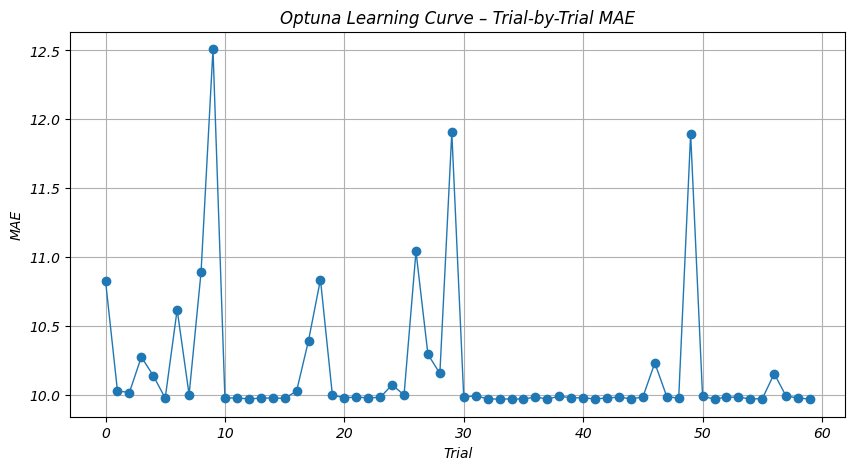

In [12]:
# Tüm trial skorlarını çekelim
trial_numbers = []
trial_mae = []

for t in study.trials:
    if t.value is not None:   # başarısız trial'ları at
        trial_numbers.append(t.number)
        trial_mae.append(t.value)

plt.figure(figsize=(10, 5))
plt.plot(trial_numbers, trial_mae, marker="o", linewidth=1)
plt.xlabel("Trial")
plt.ylabel("MAE")
plt.title("Optuna Learning Curve – Trial-by-Trial MAE")
plt.grid(True)
plt.show()


In [14]:
best_params = study.best_params
best_params

{'n_estimators': 393,
 'max_depth': 13,
 'min_samples_split': 3,
 'min_samples_leaf': 6,
 'max_features': 0.5}

In [11]:
best_rf = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)


,n_estimators,393
,criterion,'squared_error'
,max_depth,13
,min_samples_split,3
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
y_pred = best_rf.predict(X_test)

print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2:", r2_score(y_test, y_pred))

Test MAE: 9.858565087747392
Test RMSE: 14.992125731869038
Test R2: 0.6014424167122914


In [16]:
explainer = shap.TreeExplainer(best_rf)

# Test setini açıklayacağız
shap_values = explainer.shap_values(X_test)

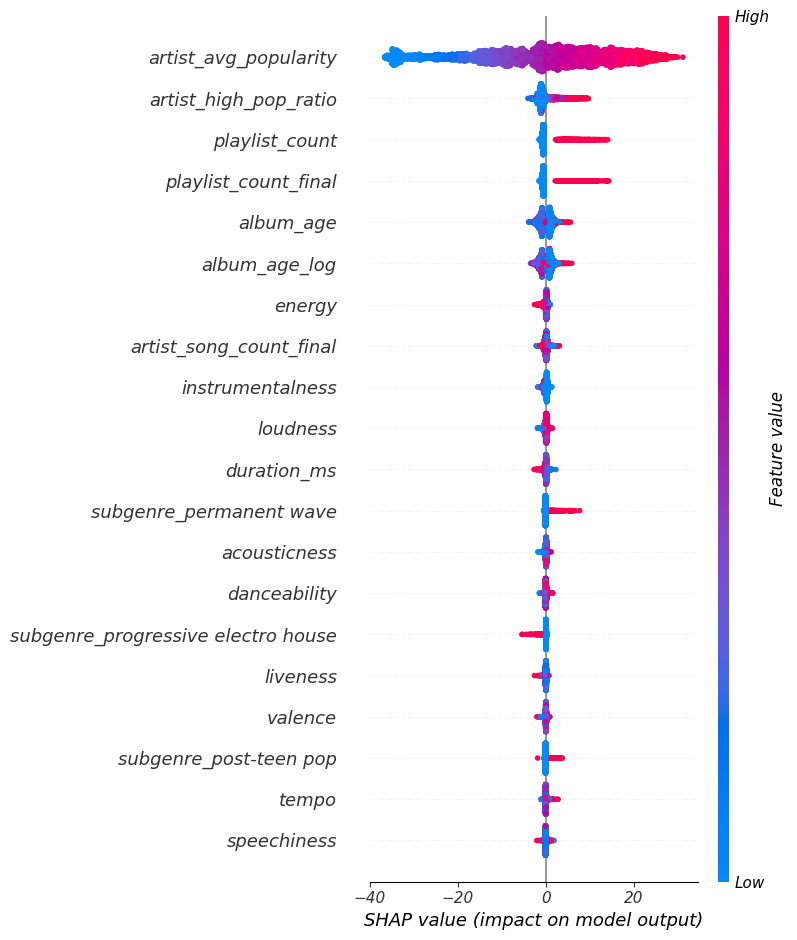

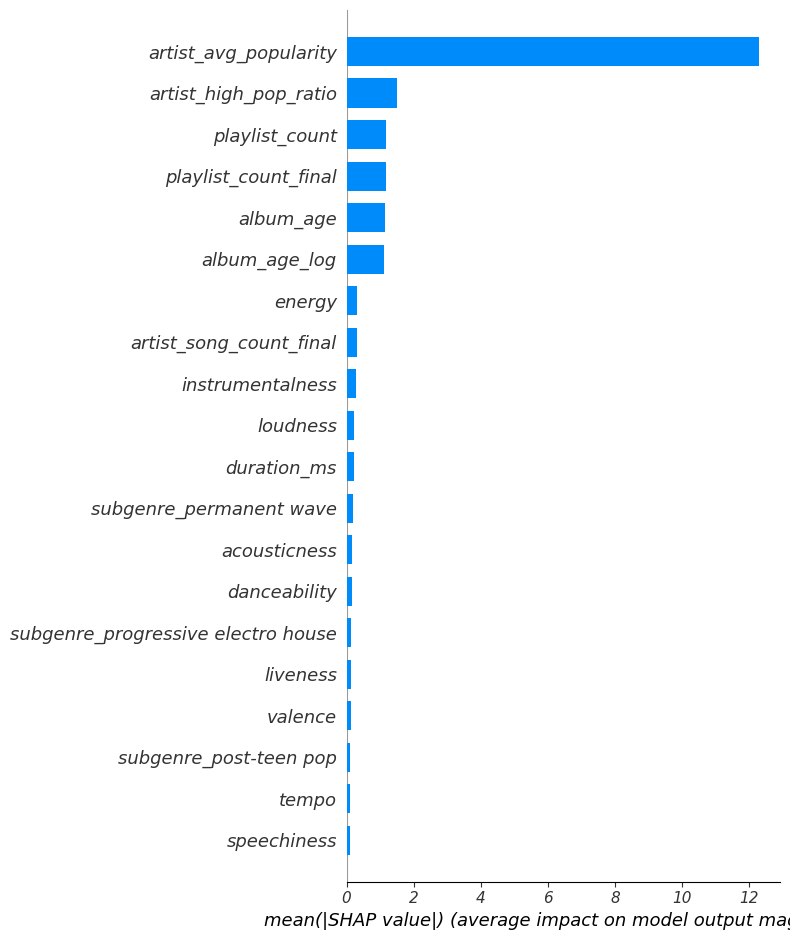

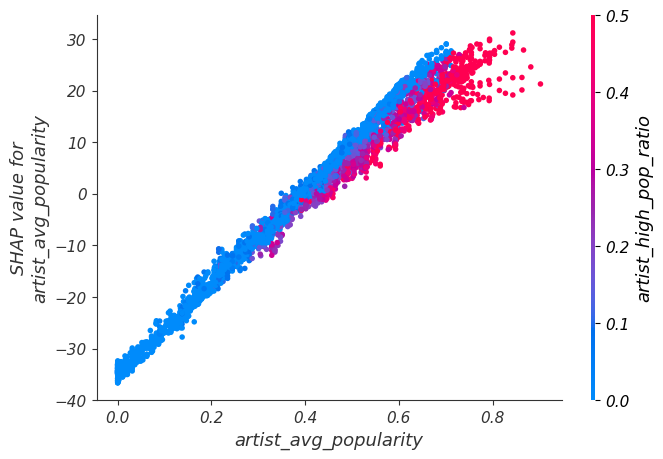

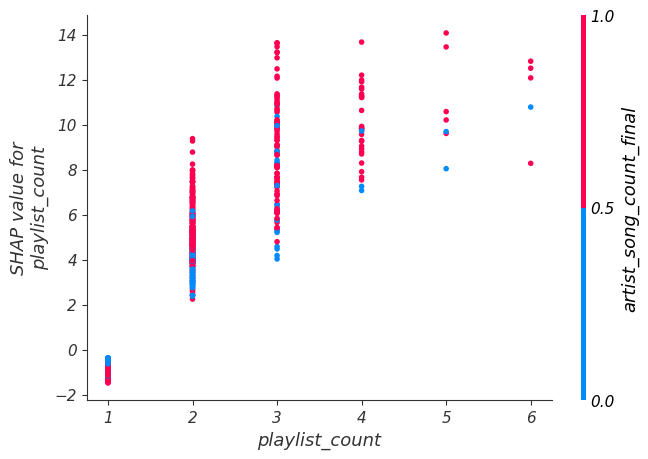

In [17]:
shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.dependence_plot("artist_avg_popularity", shap_values, X_test)

shap.dependence_plot("playlist_count", shap_values, X_test)

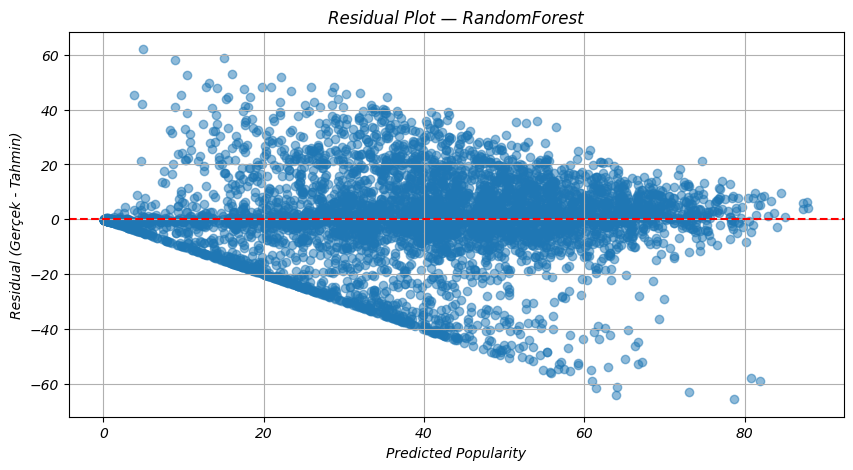

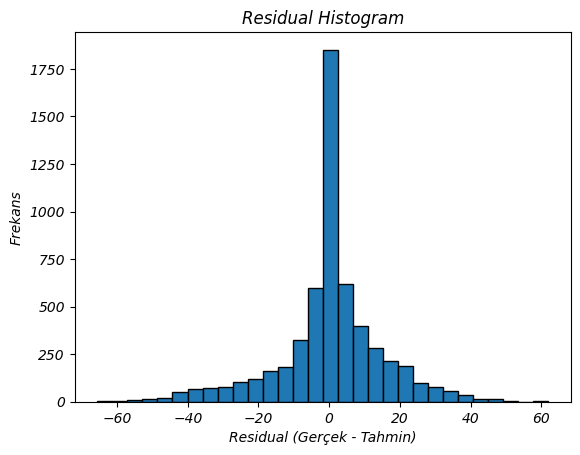

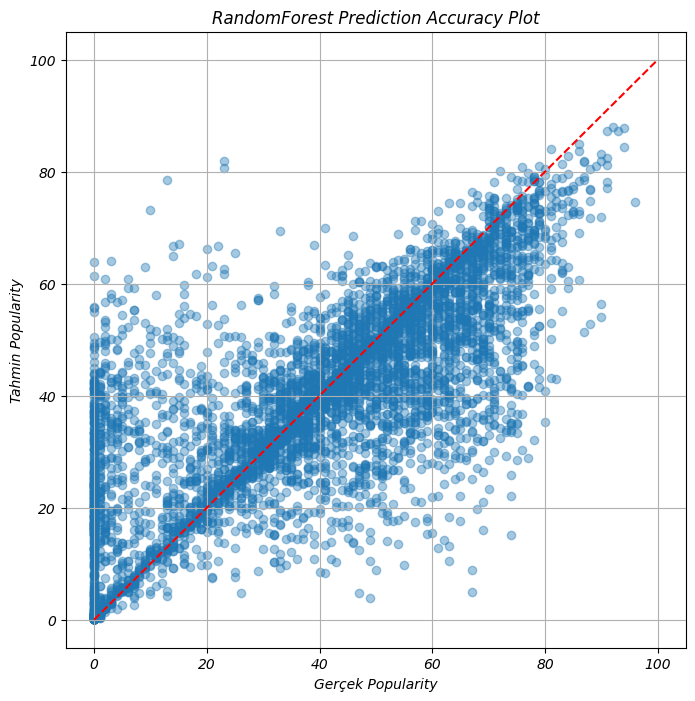

In [18]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Popularity")
plt.ylabel("Residual (Gerçek - Tahmin)")
plt.title("Residual Plot — RandomForest")
plt.grid(True)
plt.show()

plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residual Histogram")
plt.xlabel("Residual (Gerçek - Tahmin)")
plt.ylabel("Frekans")
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel("Gerçek Popularity")
plt.ylabel("Tahmin Popularity")
plt.title("RandomForest Prediction Accuracy Plot")
plt.grid(True)
plt.show()


>>> Plotting 1D Partial Dependence for: ['artist_avg_popularity', 'playlist_count', 'artist_high_pop_ratio', 'album_age']


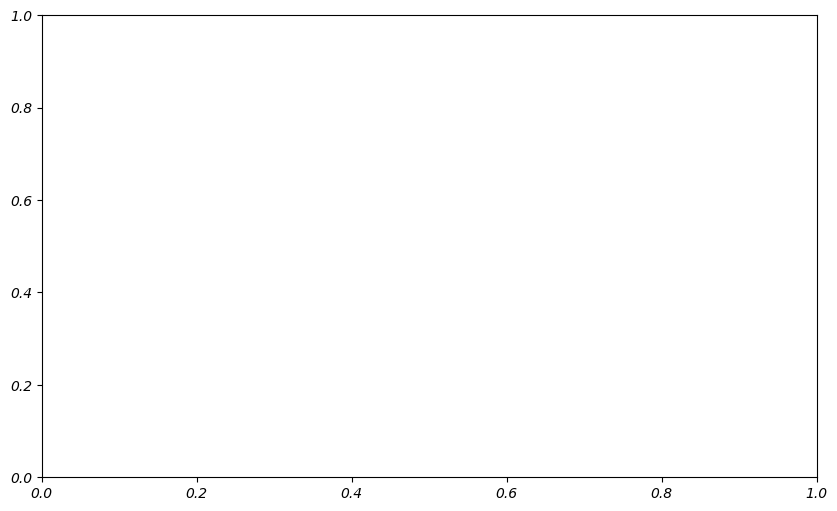

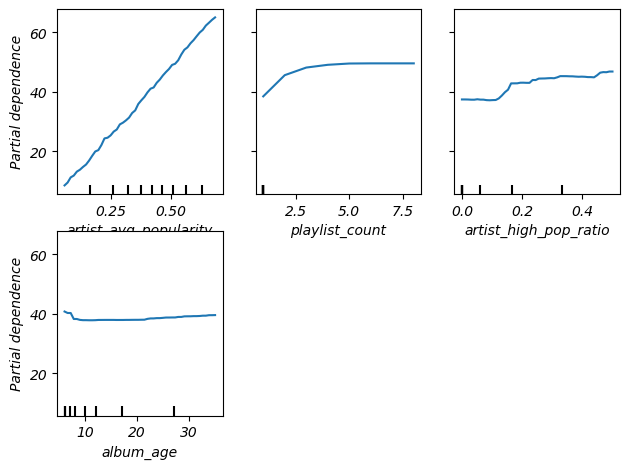

In [19]:
features = ["artist_avg_popularity", "playlist_count", "artist_high_pop_ratio", "album_age"]

features_for_pdp = []

for f in features:
    if f in X.columns:
        features_for_pdp.append(f)

if features_for_pdp:
    print("\n>>> Plotting 1D Partial Dependence for:", features_for_pdp)
    fig, ax = plt.subplots(figsize=(10, 6))
    PartialDependenceDisplay.from_estimator(
        best_rf,
        X_train,
        features_for_pdp,
        kind="average",
        grid_resolution=50
    )
    plt.tight_layout()
    plt.show()

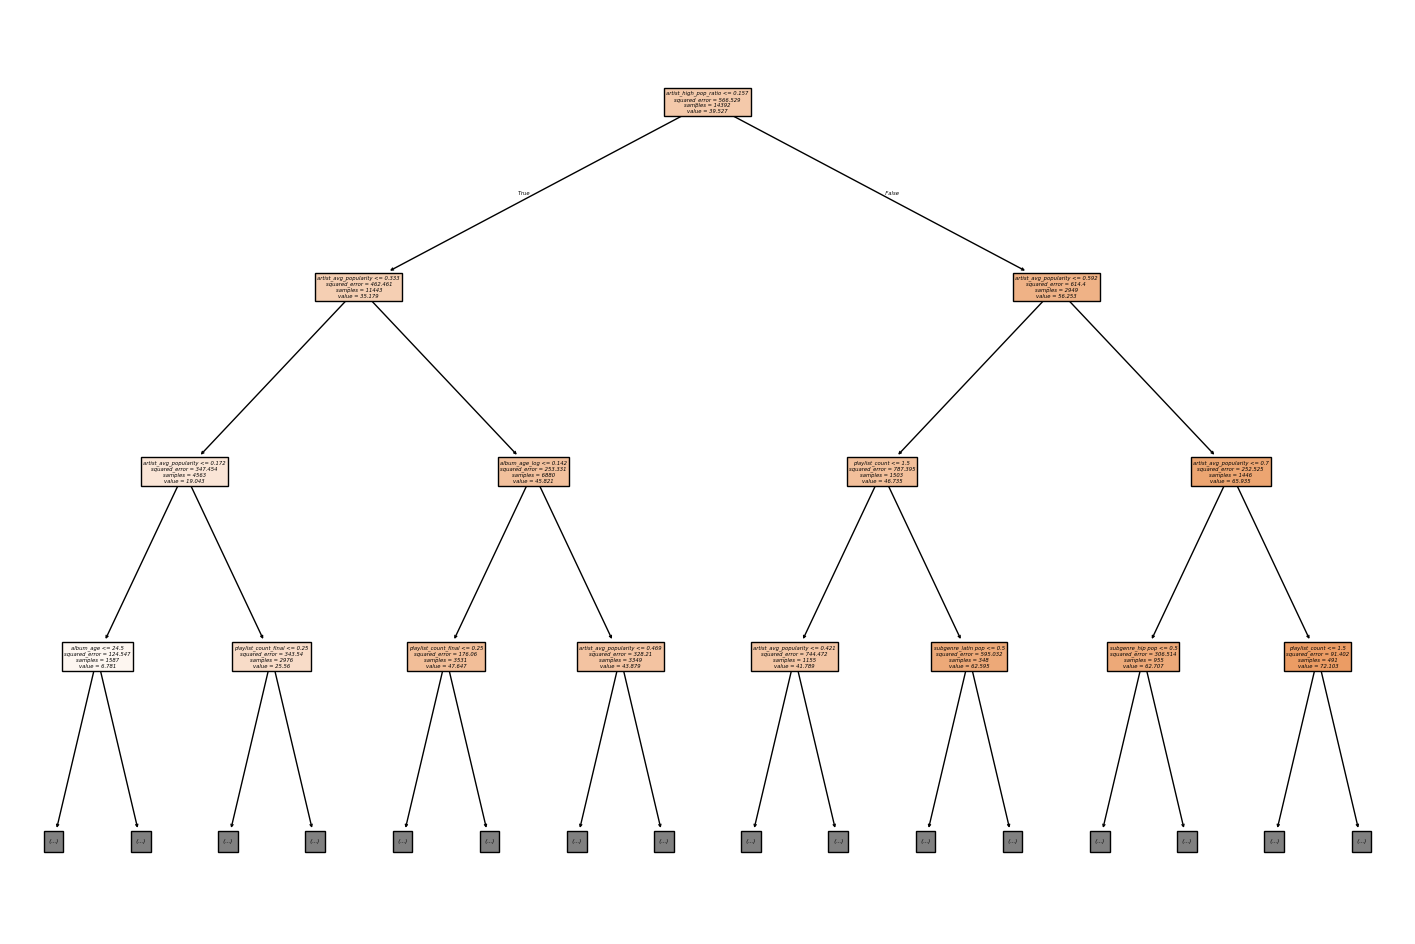

In [20]:
estimator = best_rf.estimators_[0]

from sklearn.tree import plot_tree
plt.figure(figsize=(18, 12))
plot_tree(estimator, feature_names=X_train.columns, filled=True, max_depth=3)
plt.show()

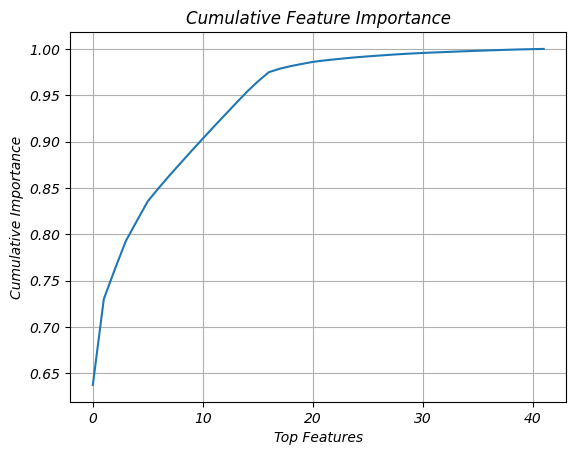

In [21]:
imp = best_rf.feature_importances_
sorted_imp = np.sort(imp)[::-1]
cumulative = np.cumsum(sorted_imp)

plt.plot(cumulative)
plt.xlabel("Top Features")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance")
plt.grid(True)
plt.show()


Top 20 features by importance:
                    feature  importance
36    artist_avg_popularity    0.637294
37    artist_high_pop_ratio    0.092688
11           playlist_count    0.032015
40     playlist_count_final    0.030615
39            album_age_log    0.021648
38                album_age    0.021320
10              duration_ms    0.014394
2                  loudness    0.013803
1                    energy    0.013264
9                     tempo    0.013226
0              danceability    0.012901
5              acousticness    0.012845
4               speechiness    0.012632
7                  liveness    0.012511
8                   valence    0.012434
41  artist_song_count_final    0.011184
6          instrumentalness    0.010093
27  subgenre_permanent wave    0.003794
29   subgenre_post-teen pop    0.002804
19       subgenre_hard rock    0.002305


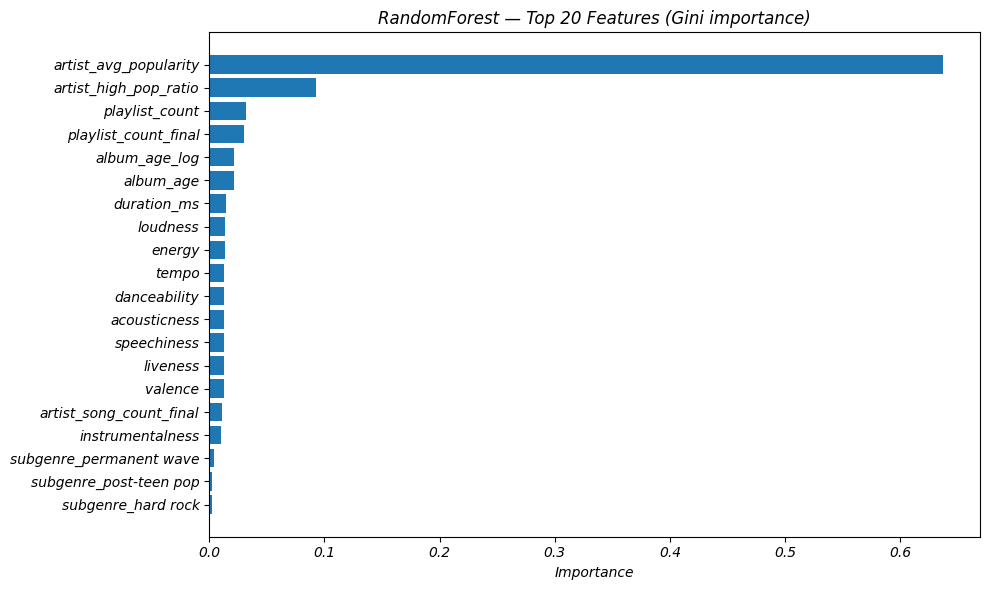

In [22]:
# Feature Importances
importances = best_rf.feature_importances_

feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
})
feature_importance = feature_importance.sort_values("importance", ascending=False)

print("\nTop 20 features by importance:")
print(feature_importance.head(20))

# Bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["feature"].head(20),
         feature_importance["importance"].head(20))
plt.gca().invert_yaxis()
plt.title("RandomForest — Top 20 Features (Gini importance)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()